# Evidence of Things Unheard: Fourier Transforms and Signal Processing

The goal of this project is to apply what we have been studying concerning signal processing and the discrete fourier transform to music analysis.

Specifically, you will:

1) Study how a gaussian filter works, and then implement a filter of your own choice.

Goals:
  * implement Gaussian Filter in time and frequency domain, understand convolutions
  * understand normalization in discrete and continuous fourier transforms
  * create custom filter and characterize performance using qualtative and quantitative metrics

2) Implement a Short-Time Fourier Transform (STFT) and use it to analyze a piece of music to understand the frequency characteristics.

Goals:
* construct STFT
* characterize the bandwidth/time resolution trade off.

## Imports + Utility fns.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft
import librosa
from librosa import display as lr_display

# For loading audio.
from IPython.display import Audio
from scipy.io import wavfile

# For plotting.
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Sans serif"]})

# Import course files.
!git clone https://github.com/Noahyt/AM_104.git


Cloning into 'AM_104'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 39 (delta 13), reused 16 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 5.14 MiB | 17.68 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
def sample_index(time, sample_rate=44100):
  """Returns the index into a signal array correspondingt to the given time."""
  return int(time *  sample_rate)

# Audio Plots.



## $\color{orange}{\text{EXERCISE 1}}$

In this project we will be playing with sounds. To warm up we want to connect the vocabulary of music to that of physics and signal analysis. This should help get you get "acoustic intuition" for the operations we will do and practice interpreting the figures we will be making throughout this project.

\
a) What is an octave? Either sketch by hand or plot using `plt.plot` two waveforms that are an octave apart.

\
b) Pick your favorite instrument (or singer!) -- what is the typical range of this instrument in tones (or other music notation if this is a non-western instrument) and in frequency. (For example, a trumpet can play between F# below middle C to double high C -- more if you're Dizzy Gilspie :) )

\
c) We say the power $p$ in a signal is proportional to the square of the amplitude $p\propto |f(t)|^2$.

One typically measures volume in decibels or $dB$ measured by comparing the measured sound intensity $p_s$ to a reference intensity $p_0$.

$$\text{Volume} = 10\log(\frac{p_s}{p_0})$$

Again, in this case power is proportional to the square of the sound pressure $p_s\propto P^2$.

Now, imagine there are two speakers playing the same tone at the same volume.

If a microphone records the volume of one speaker alone as having volume 80dB what is the measured volume of the two speakers playing together (we assume the speakers are completely in phase)?

\
d) Imagine we have only one speaker but we double the driving voltage. This is equivalent to doubling the sound pressure put out (under assumption of linearlity). What is the measured volume of this one speaker?


ANSWERS
a) An octave is ajumpin pitch where the frequency doubles (or halves)
b) A standard piano has the lowest note: A0 with the frequency 27.5Hz and the highest note: C8 with a frequnecy of 4186 Hz.
c) We know that for onespeaker the Volumne = 80 dB. With two identical speakers, completely in phase the sound pressure doubles and therefore the power increases by a factor of 4 so V2 = 10log(4P1/P0) which is about 86 dB
d) Doubling the voltage is doubling sound pressure and power is (pressure)^2 so we have the same factor of 4 increase in power. Therefore the answer is also 86 dB

In [5]:
# This code loads a sample from the track "Dance Yrslf Clean" by LCD Soundsytem.
# You can also load your own sample, but note that it must be in `.wav` format.

# Path to file.
sample_audio_file = "/content/AM_104/audio_analysis/lcd_soundsystem.wav"

# Load file into array.
sample, sample_rate = librosa.load(sample_audio_file)

# Find dt.
dt = 1 / sample_rate

# Define for later convenience.
length = sample.shape[0]
t = np.arange(0, length) * dt

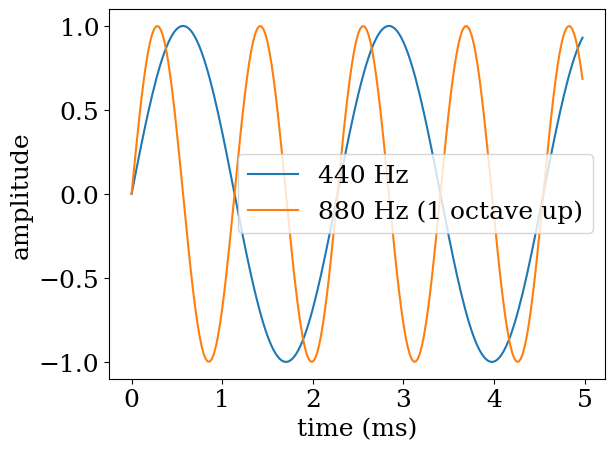

In [6]:
import numpy as np
import matplotlib.pyplot as plt

fs = 44100          # sampling rate
T = 0.005           # show just a few ms so the waves are visible
t = np.linspace(0, T, int(fs*T), endpoint=False)

f1 = 440            # A4
f2 = 880            # one octave above

y1 = np.sin(2*np.pi*f1*t)
y2 = np.sin(2*np.pi*f2*t)

plt.plot(t*1000, y1, label="440 Hz")
plt.plot(t*1000, y2, label="880 Hz (1 octave up)")
plt.xlabel("time (ms)")
plt.ylabel("amplitude")
plt.legend()
plt.show()


## $\color{orange}{\text{EXERCISE 2}}$


Run the following code cell.
It will generate an audio clip you can play\* and a visualization of the waveform.

a) In words, describe the features of this plot. What are the x- and y- axes? Modify the code to add the correct labels to the plot.

b) Geometrically, what is the "volume" in the sense defined in the previous section.


\** by default this is `Dance Yrslf Clean` by `LCD Soundsystem` but if you want you can change this by uploading your own and changing the appropriate lines in the cell above

Text(0, 0.5, 'y label')

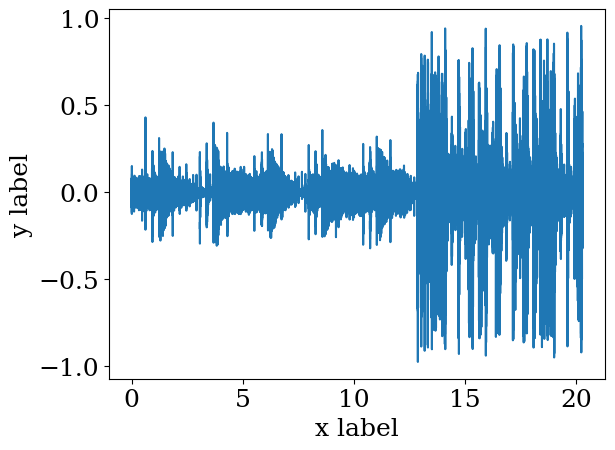

In [4]:
# Play Sample.
display(Audio(sample, rate=sample_rate))
plt.plot(t, sample)
plt.xlabel('x label')
plt.ylabel('y label')

## Select a smaller window of time.

In [ ]:
# Demonstration of how to slice out a particular window of time.

# Slice out the first 2.5 seconds.
time_in = 0
time_out = 2.5
intro_sample = sample[sample_index(time_in):sample_index(time_out)]
intro_sample_time = t[sample_index(time_in):sample_index(time_out)] # Time associated with `intro_sample`
sample_count = intro_sample.shape[0]

display(Audio(intro_sample, rate=sample_rate))
plt.plot(intro_sample_time, intro_sample)

# Fourier Transforms and Filtering

The code below takes the discrete fourier transform (DFT) of your audio sample and plot it the power as a function of frequency.

In [ ]:
sample_rfft = fft.rfft(sample,norm='ortho')
freq_bins = fft.rfftfreq(sample.shape[0], dt)

# Find intensity
intensity = np.abs(sample_rfft) ** 2

# Plot
plt.plot(freq_bins, sample_rfft)

plt.title("FT of signal.")

## $\color{orange}{\text{EXERCISE 3}}$


This problem builds on the DFT we showed in the cell above.

a) Find a cutoff frequency $k'$ such that 95% of the energy of the original signal would be preserved if all values of the DFT outside this frequency were set to 0. (Hint: use the definition of power above along with Parseval's theorem for the DFT).

Modify the code below (calculate the appropriate `cutoff_freq`) which will plot a vertical line at this cutoff frequency.

Hint: You may want to use
`np.sum` and `np.cumsum` to find the total and cumulative power ...


b) What is the minimum sampling rate associated with this cutoff frequency? If the song were sampled at this rate, how much could it be compressed? (I.e. what is the ratio of `compressed_samples/original_samples`)

In [ ]:
sample_rfft = fft.rfft(sample,norm='ortho')
freq_bins = fft.rfftfreq(sample.shape[0], dt)

# Find intensity
intensity = np.abs(sample_rfft) ** 2


## YOUR CODE HERE  ###

# Find frequency bin where total power below is >95% of total.
cutoff_freq =  ...

# Plot
plt.plot(freq_bins, sample_rfft)
plt.axvline(cutoff_freq, color='orange')

plt.title("FT of signal with 95% power cutoff.")

# Low Pass Filters in the time and frequency domain. (Discrete and Continous Fourier Transforms.)

We would like to convolve our audio sample with a gaussian:

$g(t) = \frac{1}{\sigma\sqrt{2\pi}}e^{\frac{-(t)^2}{\sigma^2}}$





## $\color{orange}{\text{EXERCISE 4}}$

Assume that $\mu=0$

a) Write a function that constructs this gaussian kernel in the time domain and plot it.



In [ ]:
# Finish this function.
def gaussian_filter(x, mean, std, normalize=True):
  """Returns values of gaussian with given mean and std."""

  ## YOUR CODE HERE

  return  ### GAUSSIAN

# Define Standard deviation in seconds:
std = .001

# Construct filter.
x = np.arange(-5000, 5000) * dt # time steps
filter=gaussian_filter(x, 0, std)

# Filter power. (to check normalization)
filter_power = np.sum(filter ** 2 )

# Plot.
plt.plot(x, filter)
plt.xlabel("seconds")

b) Convolve the kernel you built in a) with our sample to create a low pass filtered version of our original signal.

Note that there is some complication due to the finite nature of the sample and kernel at the edges of the convolution -- there are various strategies to handle this each with their own type of associated error.

Plot the spectrum and the time domain signal associated with the filtered sample. What does it sound like? What does changing the width of the gaussian do?



In [ ]:
filtered_signal = signal.convolve(sample, filter, mode="same", method="direct") * dt

filtered_signal = filtered_signal / np.amax(filtered_signal)
display(Audio(filtered_signal, rate=sample_rate))
plt.plot(t, filtered_signal)

c) Run the code below. This takes the DFT of the gaussian kernel you constructed for (b) and plots it against the analytical fourier transform of a continuous gaussian of the same width. Why are they different? (Hint: Think about what is conserved in the continuous and discrete fourier transform.)

In [ ]:
def fourier_gaussian(omega, mu, std):
  return np.exp(-.5 * (( (omega - mu) * std ) ** 2 ))

# Compute filter numerically (using dft)
filter_ft_numerical = np.fft.fft(filter, n=sample.shape[0], norm="ortho")

sample_fft = np.fft.fft(sample,norm='ortho')
freq_bins = freq_bins = np.fft.fftfreq(sample.shape[0], dt)

# Compute filter analytically (using expression for ft of gaussian).
filter_ft_analytic=fourier_gaussian(freq_bins * 2 * np.pi, 0., std)

half = sample.shape[0] //2

# Plot both analytic and numerical versions of fourier domain filter.
plt.plot(freq_bins[:half], np.abs(filter_ft_numerical)[:half], label="Numerical")
plt.plot(freq_bins[:half], filter_ft_analytic[:half], linestyle='dashed', label="Analytic")
plt.xlabel("Hz")
plt.legend()

d) **[[ EXTRA CREDIT ]]** Based on your answer to part (c) construct an apropriate scaling factor and plot both the analytical and discrete fourier transforms.

Hint, think about power conservation between the time- and frequency-domain filters (Parseval's Theorem)

In [ ]:

## YOUR CODE HERE
filter_ft_numerical_norm = ...
filter_ft_analytic = ...

# Plot both analytic and numerical versions of fourier domain filter.
plt.plot(freq_bins[:half], np.abs(filter_ft_numerical_norm)[:half], label="Numerical Norm")
plt.plot(freq_bins[:half], filter_ft_analytic[:half], linestyle='dashed', label="Analytic")
plt.xlabel("Hz")
plt.legend()


e) Implement the same convolution you did in (b) in the frequency domain by using the convolution property of the DFT and either the discrete or analytical kernel. Does it sound the same as the calculation you did in the time domain?

Hint: you will want to use `fft.rfft` and `fft.irfft`


In [ ]:
## YOUR CODE HERE

fourier_filtered_sample = # something ...

# Normalize.
fourier_filtered_sample = fourier_filtered_sample / np.amax(fourier_filtered_sample)

# Plot.
display(Audio(fourier_filtered_sample, rate=sample_rate))
plt.plot(t, fourier_filtered_sample)




# Other Filters (Shifting Property)

The following code defines a `modulated_gaussian_filter` that has the following form:

$$\text{modulated gaussian filter}(t) = \frac{1}{\sigma\sqrt{2\pi}}e^{\frac{-x^2}{\sigma^2}}e^{-ixa}$$

where a is a free parameter and plots it kernel in the time domain.

Note that this is just a normal gaussian with an added modulation term $\sim e^{-ixa}$

In [ ]:
def gaussian_filter(x, mean, std, normalize=True):
  """Returns values of gaussian with given mean and std."""
  a = 1.
  if normalize:
    a = 1 / (std * np.sqrt(2 * np.pi))
  return a * np.exp(-.5 * (x-mean) **2 / (std ** 2))

# Define Standard deviation in seconds:
std = .001

# Construct filter.
x = np.arange(-5000, 5000) * dt # Sample
filter=gaussian_filter(x, 0, std)


# Add oscillation:
freq_center_hz = 400
freq_center_omega = 2 * np.pi * freq_center_hz
filter = filter * np.exp(1j * x * freq_center_omega)

filter_power = np.sum(filter ** 2)

# Plot.
plt.plot(x, filter)
plt.xlabel("seconds")
plt.title("Time domain filter")


The following code plots the same kernel in the fourier domain.

In [ ]:
# Compute filter numerically (using dft)

# Compute how much we need to pad to make filter the same length as signal.
pad_amt = sample.shape[0] - filter.shape[0]

# Compute pad on each side.
pad_left = int(pad_amt // 2)
pad_right = pad_amt - pad_left

# Pad original filter
filter_padded = np.pad(filter, [[pad_left, pad_right]])
filter_ft_numerical = np.fft.rfft(filter_padded, norm='ortho')

# Plot fourier domain filter.
plt.plot(freq_bins, np.abs(filter_ft_numerical), label="Numerical")
plt.xlabel("Hz")
plt.legend()


## $\color{orange}{\text{EXERCISE 5}}$

Convolve your signal with this new kernel. What does the result sound like?

Can you provide a simple interpretation? Hint: Remember the shift propery of the fourier transform.

Feel free to take the FT of the filtered signal and compare it to previous results.

In [ ]:
# Convolves signal and filter.

filtered_signal = signal.convolve(sample, filter, mode="same", method="direct")


filtered_signal = filtered_signal / np.amax(filtered_signal)
display(Audio(filtered_signal, rate=sample_rate))
plt.plot(t, filtered_signal)

# STFT and Spectrograms

Although the fourier transform is extremely useful in illustrating global properties of a signal, it masks changes in frequency content over the length of a signal.


## $\color{orange}{\text{EXERCISE 6}}$

The following code takes the DFT of the first and last half of your sample separately and plots them on the same figure.

a) Are they identical? Why or why not?



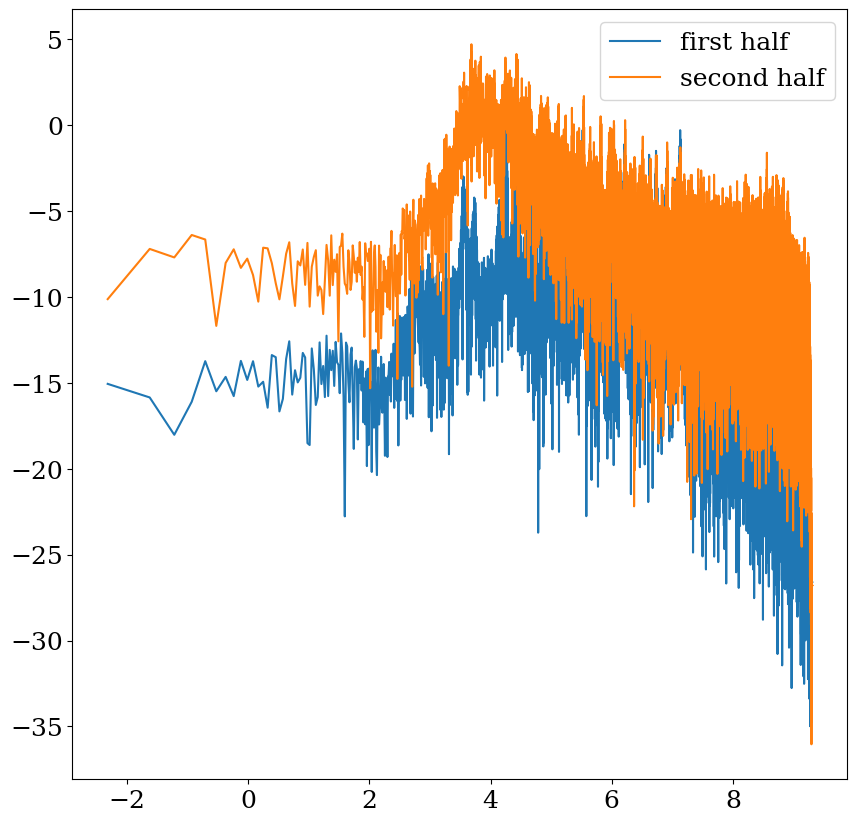

In [ ]:
halfway = int(len(sample) // 2)

sample_first_half = sample[:halfway]
sample_second_half = sample[halfway:]

sample_first_fft = fft.rfft(sample_first_half,norm='ortho')
freq_first_bins = fft.rfftfreq(sample_first_half.shape[0], dt)

sample_second_fft =fft.rfft(sample_second_half,norm='ortho')
freq_second_bins = fft.rfftfreq(sample_second_half.shape[0], dt)


# Plot.
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot
freq_scaled = np.log(freq_first_bins[1:])
amp_scaled = np.log2(np.abs(sample_first_fft[1:]) ** 2)
ax.plot(freq_scaled, amp_scaled, label="first half")

freq_scaled = np.log(freq_second_bins[1:])
amp_scaled = np.log2(np.abs(sample_second_fft[1:]) ** 2)
ax.plot(freq_scaled, amp_scaled, label="second half")


plt.legend()

We would like to generalize the operation you performed in the previous part by constructing what is known as the Short time Fourier Transform (STFT), closely related to a spectrogram. By moving from 1 to 2D representation we can observe both time and frequency information in one picture!

b) Run the code below -- coment on some feature you see in the spectrogram.

<ipython-input-22-bc1a6884097c>:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  lr_display.specshow(librosa.amplitude_to_db(stft, ref=np.max), y_axis='log', x_axis='time', ax=ax)


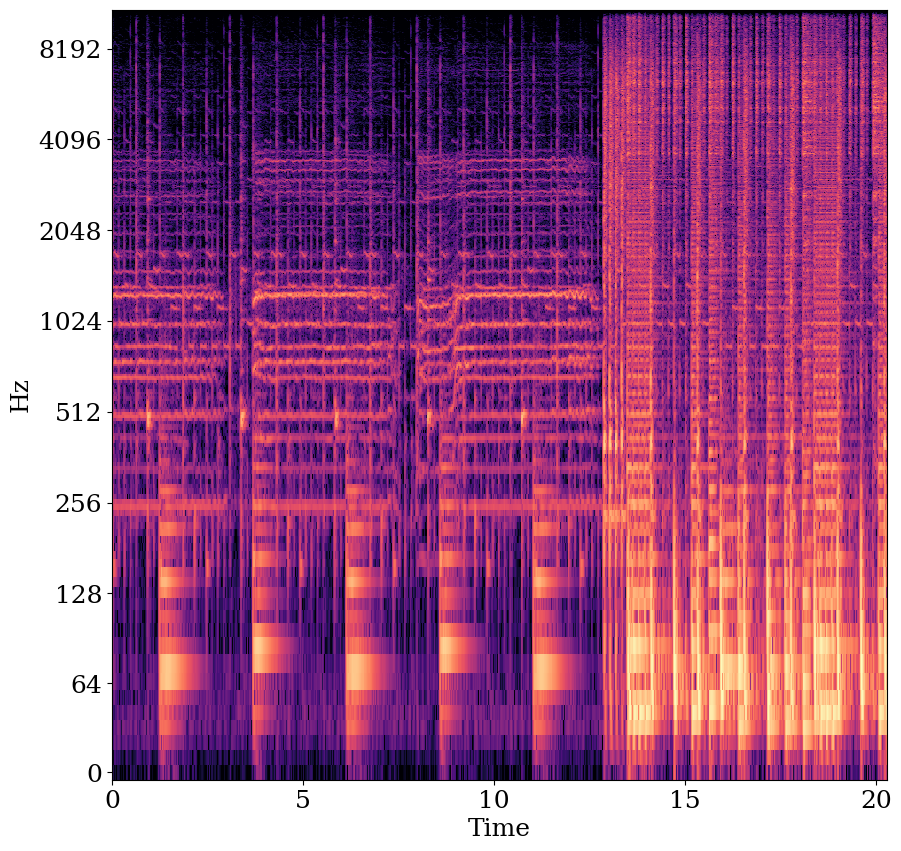

In [ ]:
# Take STFT using `librosa`.
stft = librosa.stft(sample)

# Plot.
fig, ax = plt.subplots(figsize=(10, 10))
lr_display.specshow(librosa.amplitude_to_db(stft, ref=np.max), y_axis='log', x_axis='time', ax=ax)

In the continous case the STFT is defined as:

$\textbf{STFT(f)}(x, k) = \int_{-\infty}^{\infty}f(x')w(x'-x)e^{-ixk}dx$

Where $w$ is a windowing function, for instance a gaussian window. (There are many other types of windows -- Hann, Hamming, rectangular, Flat-top, b-spline, .... see: https://en.wikipedia.org/wiki/Window_function#A_list_of_window_functions)
